In [1]:
import numpy as np
import os
import sys
import torch
import pytorch3d

import matplotlib.pyplot as plt

import trimesh
from pytorch3d.io import load_objs_as_meshes, save_obj
import numpy as np
from tqdm.notebook import tqdm

from src.cleansed_cube import ProgressiveCube

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
)

from src.plot_image_grid import image_grid

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


obj_filename = "./data/bunny.obj"
obj_filename = "./data/nefertiti.obj"
bunny = load_objs_as_meshes([obj_filename], device=device)

textures=TexturesVertex(verts_features=[torch.ones_like(bunny.verts_packed())])

bunny = Meshes(verts=[bunny.verts_packed()], 
           faces=[bunny.faces_packed()],
           textures=textures)

verts = bunny.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
bunny.offset_verts_(-center)
bunny.scale_verts_((1.0 / float(scale)));

In [3]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 32

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...])

bunnies = bunny.extend(num_views)

In [4]:
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

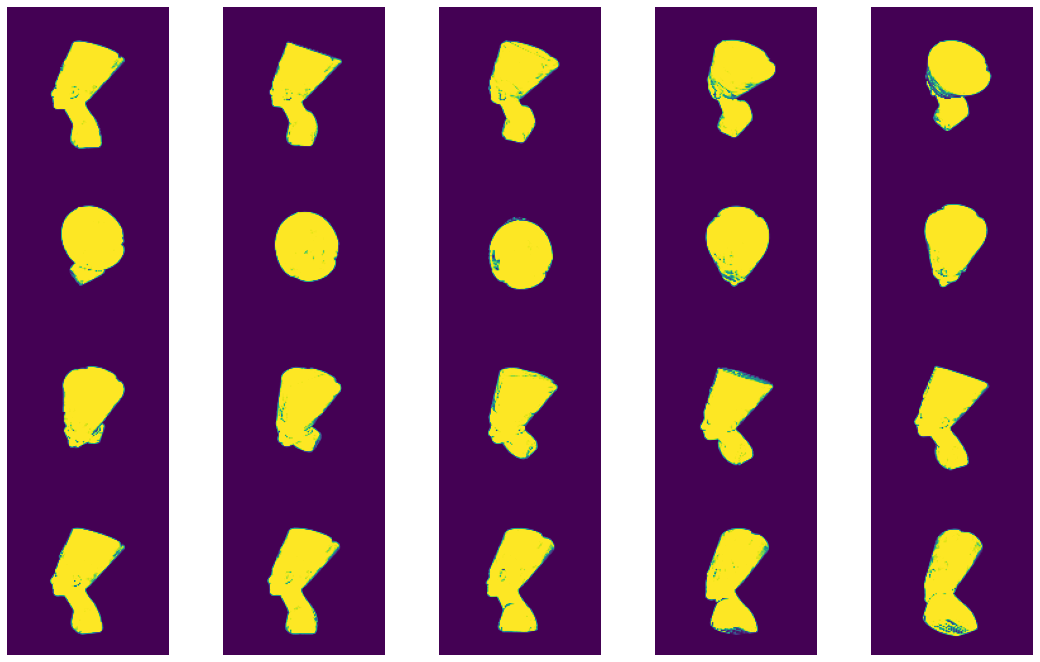

In [5]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=150, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(bunnies, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In [6]:
silhouette_images.shape

torch.Size([32, 128, 128, 4])

In [7]:
n, kernel, sigma = 8, 3, 1

cube = ProgressiveCube(n, kernel=kernel, sigma=sigma).to(device)

# self.gaussian(p.data.grad)

# clip_value = 0.1
# for p in cube.params.values():
#     #print(p)
#     p.register_hook(lambda grad: print(grad.shape) or torch.clamp(grad, -clip_value, clip_value))
#cube.export(f'./data/cube_mesh{n}.obj')
optimizer = torch.optim.SGD(cube.parameters(), lr=0.1, momentum=0.)
#optimizer = torch.optim.Adam(cube.parameters(), lr=0.001)
optimizer

3


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)

In [8]:
Niter = 100000
num_views_per_iteration = 2

loop = tqdm(range(Niter))

laplace_weight =  0.1

for i in loop:
    stop = False
#    with torch.autograd.detect_anomaly():
    optimizer.zero_grad()

    # Deform the mesh
    #new_src_mesh = src_mesh.offset_verts(torch.sigmoid(deform_verts))
    new_src_mesh, laplace_loss = cube.forward()
    verts=new_src_mesh.vertices[:, :, :3]
    textures = TexturesVertex(verts_features=torch.ones_like(verts))
    p3d_mesh = Meshes(verts=verts,
                  faces=new_src_mesh.faces[None],
                  textures=textures)
    
    #laplacian_smoothing = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    sum_loss = torch.tensor(0.0, device=device) #+ laplace_loss * laplace_weight
    #print(laplace_loss.item(), laplacian_smoothing.item())
#     sum_loss += mesh_edge_loss(new_src_mesh) * 1.0
#     sum_loss += mesh_normal_consistency(new_src_mesh) * 0.01
#     sum_loss += mesh_laplacian_smoothing(new_src_mesh, method="uniform") * 1.0
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(p3d_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        if not torch.isnan(loss_silhouette):            
            sum_loss += loss_silhouette / num_views_per_iteration            
        else:
            print('singularity', i)
            #for p in cube.params.values():
            #    torch.nan_to_num_(p.data)
            stop = True
    
    if stop:
        print(i)
        cube.export(f'./data/cube_mesh_{n}_{i}.obj')
#         pytorch3d.io.save_ply(f'./data/deformed{i}.ply', 
#             new_src_mesh.verts_packed(),
#             faces=new_src_mesh.faces_packed())
        break
        
    loop.set_description("total_loss = %.6f" % sum_loss)
    if sum_loss > 0:
        sum_loss.backward()
        cube.smooth()
        optimizer.step()
    
    if i % 2500 == 0:
        f = f'./data/cube_mesh_{n}_{i}.obj'
        cube.export(f)
        print(f)
#kernel = 0
f = f'./data/cube_mesh_{n}_{kernel}.obj'
cube.export(f)
f

./data/cube_mesh_8_0.obj
./data/cube_mesh_8_2500.obj
./data/cube_mesh_8_5000.obj
./data/cube_mesh_8_7500.obj
./data/cube_mesh_8_10000.obj
./data/cube_mesh_8_12500.obj
./data/cube_mesh_8_15000.obj
./data/cube_mesh_8_17500.obj
./data/cube_mesh_8_20000.obj
./data/cube_mesh_8_22500.obj
./data/cube_mesh_8_25000.obj
./data/cube_mesh_8_27500.obj
./data/cube_mesh_8_30000.obj
./data/cube_mesh_8_32500.obj
./data/cube_mesh_8_35000.obj
./data/cube_mesh_8_37500.obj
./data/cube_mesh_8_40000.obj
./data/cube_mesh_8_42500.obj
./data/cube_mesh_8_45000.obj
./data/cube_mesh_8_47500.obj
./data/cube_mesh_8_50000.obj
./data/cube_mesh_8_52500.obj
./data/cube_mesh_8_55000.obj



KeyboardInterrupt: 

In [11]:
cube.ex

<bound method SimpleCube.smooth of SimpleCube(
  (params): ParameterDict(
      (back): Parameter containing: [torch.cuda.FloatTensor of size 1x3x8x8 (GPU 0)]
      (down): Parameter containing: [torch.cuda.FloatTensor of size 1x3x8x8 (GPU 0)]
      (front): Parameter containing: [torch.cuda.FloatTensor of size 1x3x8x8 (GPU 0)]
      (left): Parameter containing: [torch.cuda.FloatTensor of size 1x3x8x8 (GPU 0)]
      (right): Parameter containing: [torch.cuda.FloatTensor of size 1x3x8x8 (GPU 0)]
      (top): Parameter containing: [torch.cuda.FloatTensor of size 1x3x8x8 (GPU 0)]
  )
  (source): SourceCube()
  (gaussian): DiscreteGaussian(
    (seq): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), groups=3, bias=False)
    )
  )
  (laplacian): DiscreteLaplacian(
    (seq): Sequential(
      (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), groups=3, bias=False)
    )
  )
)>

In [28]:
verts=new_src_mesh.vertices[:, :, :3]
textures = TexturesVertex(verts_features=torch.ones_like(verts))
mesh = Meshes(verts=verts,
              faces=new_src_mesh.faces[None],
              textures=textures)
mesh

In [18]:
new_src_mesh.faces.shape

torch.Size([764, 3])

In [10]:
from pytorch3d.io import save_obj

mesh, _ = cube.forward()
mesh = mesh.detach()
f = f'./data/cube_mesh_{n}.obj'
save_obj(f, mesh.verts_packed(), mesh.faces_packed())   

In [11]:
for p in cube.params.values():
    print(p.abs().max())

tensor(0.7266, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7753, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.4739, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.5460, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8304, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7907, device='cuda:0', grad_fn=<MaxBackward1>)


In [12]:
import torch.nn as nn

n = 8
params = nn.ParameterDict({
    'front': nn.Parameter(torch.zeros((1, 3, n, n))),
    'back' : nn.Parameter(torch.zeros((1, 3, n, n))),
    'left' : nn.Parameter(torch.zeros((1, 3, n, n))),
    'right': nn.Parameter(torch.zeros((1, 3, n, n))),
    'top'  : nn.Parameter(torch.zeros((1, 3, n, n))),
    'down' : nn.Parameter(torch.zeros((1, 3, n, n))),
})
params

ParameterDict(
    (back): Parameter containing: [torch.FloatTensor of size 1x3x8x8]
    (down): Parameter containing: [torch.FloatTensor of size 1x3x8x8]
    (front): Parameter containing: [torch.FloatTensor of size 1x3x8x8]
    (left): Parameter containing: [torch.FloatTensor of size 1x3x8x8]
    (right): Parameter containing: [torch.FloatTensor of size 1x3x8x8]
    (top): Parameter containing: [torch.FloatTensor of size 1x3x8x8]
)

In [13]:
torch.cat([p[0].reshape(3, -1).t()
   for p in params.values()]).shape

torch.Size([384, 3])

In [14]:
torch.cat([p for p in params.values()]).shape

torch.Size([6, 3, 8, 8])

In [15]:
from src.discrete_laplacian import DiscreteLaplacian

laplacian = DiscreteLaplacian()
laplacian

DiscreteLaplacian(
  (seq): Sequential(
    (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), groups=3, bias=False)
  )
)

In [16]:
laplacian(torch.cat([p for p in params.values()]))

tensor(0., grad_fn=<MeanBackward0>)

In [17]:
ps = torch.cat([p for p in params.values()])
ps.shape

torch.Size([6, 3, 8, 8])

In [18]:
ps.permute(0, 2, 3, 1).reshape(-1, 3).shape

torch.Size([384, 3])

In [19]:
laplacian(ps)

tensor(0., grad_fn=<MeanBackward0>)

In [20]:
import torch.nn as nn

nn.Parameter()

Parameter containing:
tensor([], requires_grad=True)

In [21]:
n = 2
params = nn.ParameterDict({
    'front': nn.Parameter(torch.zeros((1, 3, n, n))+0),
    'back' : nn.Parameter(torch.zeros((1, 3, n, n))+1),
    'left' : nn.Parameter(torch.zeros((1, 3, n, n))+2),
    'right': nn.Parameter(torch.zeros((1, 3, n, n))+3),
    'top'  : nn.Parameter(torch.zeros((1, 3, n, n))+4),
    'down' : nn.Parameter(torch.zeros((1, 3, n, n))+5),
})
params

ParameterDict(
    (back): Parameter containing: [torch.FloatTensor of size 1x3x2x2]
    (down): Parameter containing: [torch.FloatTensor of size 1x3x2x2]
    (front): Parameter containing: [torch.FloatTensor of size 1x3x2x2]
    (left): Parameter containing: [torch.FloatTensor of size 1x3x2x2]
    (right): Parameter containing: [torch.FloatTensor of size 1x3x2x2]
    (top): Parameter containing: [torch.FloatTensor of size 1x3x2x2]
)

In [22]:
ps = torch.cat([p for p in params.values()])
deform_verts = ps.permute(0, 2, 3, 1).reshape(-1, 3)
ps

tensor([[[[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.]]],


        [[[5., 5.],
          [5., 5.]],

         [[5., 5.],
          [5., 5.]],

         [[5., 5.],
          [5., 5.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[2., 2.],
          [2., 2.]],

         [[2., 2.],
          [2., 2.]],

         [[2., 2.],
          [2., 2.]]],


        [[[3., 3.],
          [3., 3.]],

         [[3., 3.],
          [3., 3.]],

         [[3., 3.],
          [3., 3.]]],


        [[[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]],

         [[4., 4.],
          [4., 4.]]]], grad_fn=<CatBackward>)

In [23]:
ps.permute(0, 2, 3, 1)

tensor([[[[1., 1., 1.],
          [1., 1., 1.]],

         [[1., 1., 1.],
          [1., 1., 1.]]],


        [[[5., 5., 5.],
          [5., 5., 5.]],

         [[5., 5., 5.],
          [5., 5., 5.]]],


        [[[0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.]]],


        [[[2., 2., 2.],
          [2., 2., 2.]],

         [[2., 2., 2.],
          [2., 2., 2.]]],


        [[[3., 3., 3.],
          [3., 3., 3.]],

         [[3., 3., 3.],
          [3., 3., 3.]]],


        [[[4., 4., 4.],
          [4., 4., 4.]],

         [[4., 4., 4.],
          [4., 4., 4.]]]], grad_fn=<PermuteBackward>)

In [24]:
p1 = ps.permute(0, 2, 3, 1).reshape(-1, 3)
p2 = torch.cat([p[0].reshape(3, -1).t()
    for p in params.values()])  

In [25]:
torch.equal(p1, p2)


True

In [26]:
p1.contiguous()

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.],
        [5., 5., 5.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.],
        [4., 4., 4.]], grad_fn=<UnsafeViewBackward>)